# Driving Behavior Analysis

The dataset contains information about driver behavior metrics and includes a column that classifies the behavior into three categories:
- **Normal**
- **Aggressive**
- **Slow**

The goal of this analysis is to develop machine learning models that can predict the categorization based on the driving behavior metrics.

## Importing used libraries


In [2]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import KFold
import numpy as np

## Loading the Datasets, basic transformations and data exploration

Separate training and test files have already been provided. Initially, I will use these files as intended to train and evaluate the model. Later on, I will merge the datasets and use all the data for training with **KFold cross-validation** to see if it improves the model's performance.

The timestamp column was removed as it doesn't provide valueable information and caused the model to become almost 100% accurate.

Another interesting fact is that the category Slow is overrepresented in both the train and test dataset. This is especially apparent in the test dataset. It might be better to remove some of the records to balance the representation of the categories. This will be explored later on.

In [6]:
train_url = "https://raw.githubusercontent.com/GitJvG/Dataset/main/train_motion_data.csv"
test_url = "https://raw.githubusercontent.com/GitJvG/Dataset/main/test_motion_data.csv"

trainDF = pd.read_csv(train_url)

print("Dateset Information")
print(trainDF.info())
print(f"Dataset overview: {trainDF.head()}")

print("Descriptive Statistics:")
print(trainDF.describe())
testDF = pd.read_csv(test_url)

# Convert 'Class' to categorical type
catType = CategoricalDtype(categories=['AGGRESSIVE', "NORMAL", "SLOW"], ordered=True)
trainDF['Class'] = trainDF['Class'].astype(catType)
testDF['Class'] = testDF['Class'].astype(catType)

print("Class Distribution:")
print(trainDF['Class'].value_counts())
print(testDF['Class'].value_counts())

print("Data Types:")
print(trainDF.dtypes)

# Select the columns to be used for the scatter matrix (AccX, AccY, AccZ, GyroX, GyroY, GyroZ)
excluded = ["Class", "Timestamp"]
train_features = trainDF.drop(excluded, axis=1)
test_features = testDF.drop(excluded, axis=1)

Dateset Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3644 entries, 0 to 3643
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AccX       3644 non-null   float64
 1   AccY       3644 non-null   float64
 2   AccZ       3644 non-null   float64
 3   GyroX      3644 non-null   float64
 4   GyroY      3644 non-null   float64
 5   GyroZ      3644 non-null   float64
 6   Class      3644 non-null   object 
 7   Timestamp  3644 non-null   int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 227.9+ KB
None
Dataset overview:        AccX      AccY      AccZ     GyroX     GyroY     GyroZ   Class  \
0  0.000000  0.000000  0.000000  0.059407 -0.174707  0.101938  NORMAL   
1 -1.624864 -1.082492 -0.204183 -0.028558  0.051313  0.135536  NORMAL   
2 -0.594660 -0.122410  0.220502 -0.019395 -0.029322  0.087888  NORMAL   
3  0.738478 -0.228456  0.667732  0.069791 -0.029932  0.054902  NORMAL   
4  0.101741  0.777568 

## Basic reusable function to quickly test models

To reduce redundancy and be able to more easily compare different models, I made a basic function that produces a **confusion_matrix** and **classification_report** and takes the data and initialized model as parameter inputs. The function really works the same as how you would normally test a model but with the hardcoded values replaced with parameters.

In [76]:
def test_model(Model, Xtrain, Ytrain, Xtest, Ytest):
    Model.fit(Xtrain,Ytrain) #Fit the model
    Model.score(Xtest,Ytest) #Determine the score of the model
    
    Model_Prediction = Model.predict(Xtest)
    accuracy = Model.score(Xtest, Ytest)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Confusion matrix
    cm = confusion_matrix(Ytest, Model_Prediction, labels=Model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Model.classes_)
    disp.plot()
    plt.show()

    # Print classification report to check the classification performance
    print(classification_report(Ytest, Model_Prediction, target_names=Model.classes_))

## Getting some insight into the dataset

Just to get a sense for the data, I generate a scatterplot matrix to see if any of the values are strongly correlated. 

This doesn't seem to be the case.

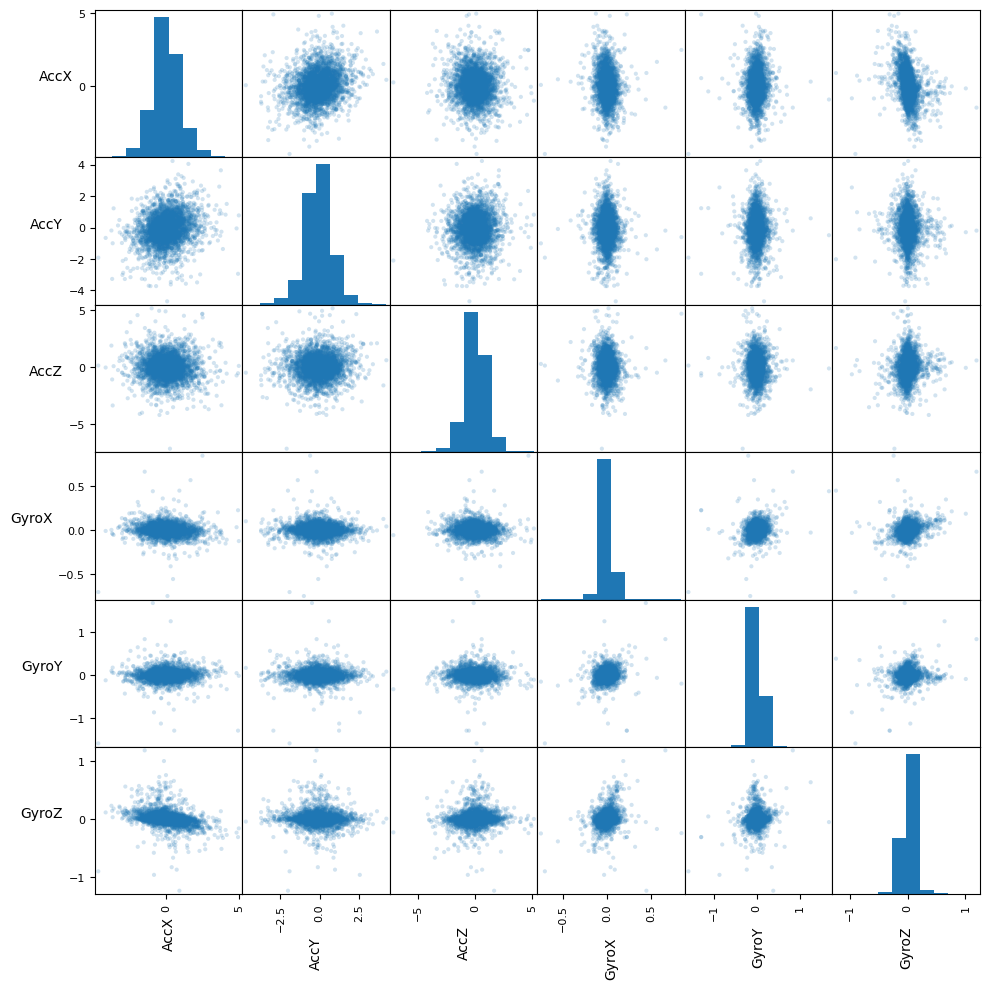

In [77]:
fig = scatter_matrix(train_features, alpha=0.2, figsize=(10, 10), diagonal="hist")

# Customize the scatter matrix plot
for ax in fig.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha("right")

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

## Preparing data for training models

This step includes normalizing the data. I chose to also make all values absolute (turning all values into positive values) because I want to measure the extremity of the value, not whether it was positive or negative. This also improved the model's accuracy quite significantly.

In [78]:
def absolute_normalize(x):
    abs_x = x.abs()  # Convert values to their absolute values
    return (abs_x - abs_x.min()) / (abs_x.max() - abs_x.min())  # Normalize the absolute values

X_train = train_features.apply(absolute_normalize, axis=0)
X_test = test_features.apply(absolute_normalize, axis=0)

y_train = trainDF["Class"]
y_test = testDF["Class"]

## Running models

In the following blocks of code several different models are tested using the previously defined function.

### K-Nearest Neighbors
This model functions by simply looking at K nearest values and their category to determine which category the data point likely belongs to.
I've expirimented with many different K values, the slope is quite steep from 5 to 21, afterwards it only slowly increases until it finally declines around 251.

KNN results:
Test Accuracy: 46.01%


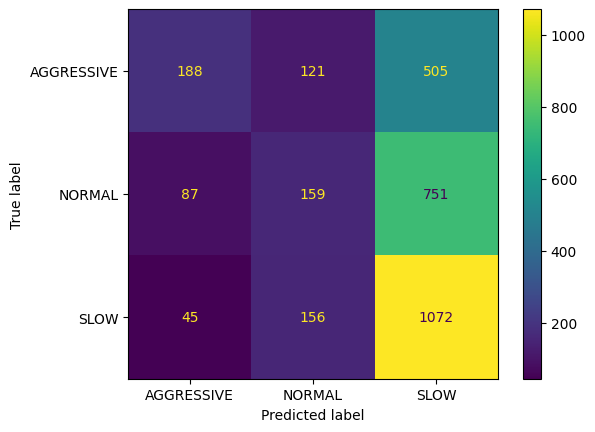

              precision    recall  f1-score   support

  AGGRESSIVE       0.59      0.23      0.33       814
      NORMAL       0.36      0.16      0.22       997
        SLOW       0.46      0.84      0.60      1273

    accuracy                           0.46      3084
   macro avg       0.47      0.41      0.38      3084
weighted avg       0.46      0.46      0.41      3084



In [117]:
knn = KNeighborsClassifier(n_neighbors=211)
print('KNN results:')
test_model(knn, X_train, y_train, X_test, y_test)

## Random Forest Classification

RandomForestClassifier results:
Test Accuracy: 41.05%


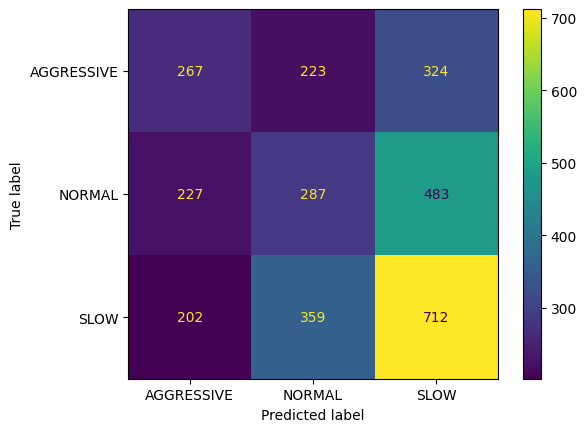

              precision    recall  f1-score   support

  AGGRESSIVE       0.38      0.33      0.35       814
      NORMAL       0.33      0.29      0.31       997
        SLOW       0.47      0.56      0.51      1273

    accuracy                           0.41      3084
   macro avg       0.39      0.39      0.39      3084
weighted avg       0.40      0.41      0.40      3084



In [80]:
RFC=RandomForestClassifier()
print('RandomForestClassifier results:')
test_model(RFC, X_train, y_train, X_test, y_test)

### GradientBoostingClassifier

GradientBoostingClassifier results:
Test Accuracy: 42.32%


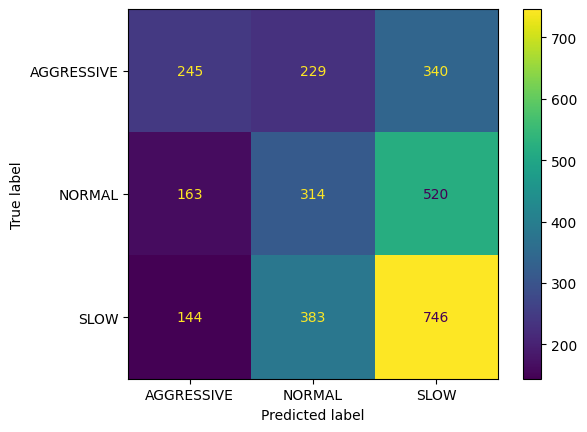

              precision    recall  f1-score   support

  AGGRESSIVE       0.44      0.30      0.36       814
      NORMAL       0.34      0.31      0.33       997
        SLOW       0.46      0.59      0.52      1273

    accuracy                           0.42      3084
   macro avg       0.42      0.40      0.40      3084
weighted avg       0.42      0.42      0.41      3084



In [81]:
GBC = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
print('GradientBoostingClassifier results:')
test_model(GBC, X_train, y_train, X_test, y_test)

### Support Vector Classification

This model returns the best accuracy metrics but clearly doesn't work well at all. This is most likely due to the overrepresentation of the Slow category.

With the second model I added an extra parameter to make the classes more balanced to hopefully get a better result.

Support Vector Classification results:
Test Accuracy: 45.36%


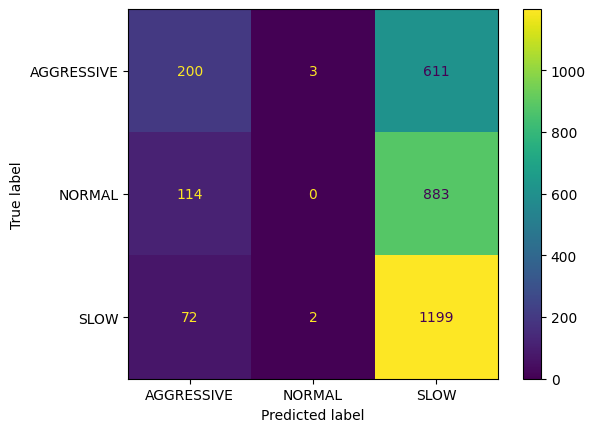

              precision    recall  f1-score   support

  AGGRESSIVE       0.52      0.25      0.33       814
      NORMAL       0.00      0.00      0.00       997
        SLOW       0.45      0.94      0.60      1273

    accuracy                           0.45      3084
   macro avg       0.32      0.40      0.31      3084
weighted avg       0.32      0.45      0.34      3084

Support Vector Classification results with tweaked parameters:
Test Accuracy: 45.23%


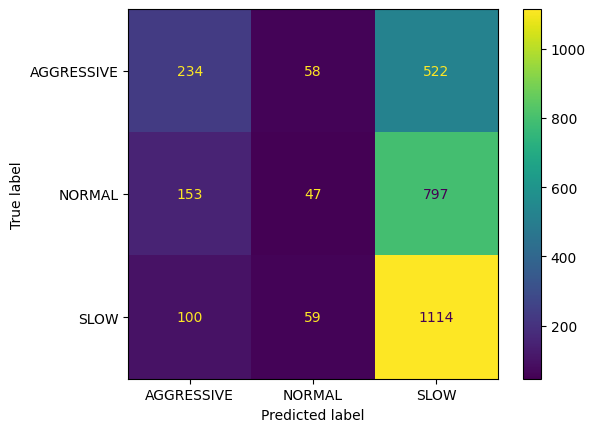

              precision    recall  f1-score   support

  AGGRESSIVE       0.48      0.29      0.36       814
      NORMAL       0.29      0.05      0.08       997
        SLOW       0.46      0.88      0.60      1273

    accuracy                           0.45      3084
   macro avg       0.41      0.40      0.35      3084
weighted avg       0.41      0.45      0.37      3084



In [82]:
SVC1 = SVC(kernel='rbf', C=1, gamma='auto')
print('Support Vector Classification results:')
test_model(SVC1, X_train, y_train, X_test, y_test)

"""Attempting to improve the model with extra parameters"""
SVC2 = SVC(kernel='rbf', C=1, gamma='auto', class_weight='balanced')
print('Support Vector Classification results with tweaked parameters:')
test_model(SVC2, X_train, y_train, X_test, y_test)

## Evaluation

None of the models perform very well, with an accuracy of around 0.3-0.45.

As a last resort I will attempt to run these models again using **KFold cross-validation** on an appended Dataframe of the test and train dataset.
I also made a reusable function to test model with KFolds. This function calculates the metrics for every fold and finally calculates and prints the averages to get a sense of the performance of the final model.

In [92]:
def test_model_kfold(Model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Initialize accumulators for precision, recall, f1-score, and support
    precision_acc = []
    recall_acc = []
    f1_acc = []
    support_acc = []
    accuracy_acc = []

    # KFold cross-validation loop
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit the model
        Model.fit(X_train, y_train)

        # Predict on test set
        y_pred = Model.predict(X_test)

        # Collect precision, recall, f1-score, support
        precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred, average=None, labels=Model.classes_)
        accuracy = accuracy_score(y_test, y_pred)
        
        precision_acc.append(precision)
        recall_acc.append(recall)
        f1_acc.append(f1)
        support_acc.append(support)
        accuracy_acc.append(accuracy)

    # Convert accumulators to numpy arrays for easier summation
    precision_acc = np.array(precision_acc)
    recall_acc = np.array(recall_acc)
    f1_acc = np.array(f1_acc)
    support_acc = np.array(support_acc)
    accuracy_acc = np.array(accuracy_acc)

    # Compute averages across all folds
    avg_precision = np.mean(precision_acc, axis=0)
    avg_recall = np.mean(recall_acc, axis=0)
    avg_f1 = np.mean(f1_acc, axis=0)
    total_support = np.sum(support_acc, axis=0)  # Sum of support across folds
    avg_accuracy = np.mean(accuracy_acc, axis=0)

    results = pd.DataFrame({
        "Class": Model.classes_,
        "Precision": avg_precision,
        "Recall": avg_recall,
        "F1-Score": avg_f1,
        "Support": total_support.astype(int)
    })

    # Display the result table
    print(results.to_string(index=False))  # Disable the index for cleaner display
    print(f"\nAverage Accuracy: {avg_accuracy * 100:.2f}%")

## Prepare data for Kfold

When using Kfold the preparation of the data has to be adjusted slightly to create on big dataset for which folds will be generated. 

In [84]:
# Combine train and test datasets
combinedDF = pd.concat([trainDF, testDF], ignore_index=True)

# Select the columns to be used for the scatter matrix (AccX, AccY, AccZ, GyroX, GyroY, GyroZ)
excluded = ["Class", "Timestamp"]
combined_features = combinedDF.drop(excluded, axis=1)

# Function to normalize absolute values
def absolute_normalize(x):
    abs_x = x.abs()  # Convert values to their absolute values
    return (abs_x - abs_x.min()) / (abs_x.max() - abs_x.min())  # Normalize the absolute values

# Apply normalization
K_fold_X = combined_features.apply(absolute_normalize, axis=0)
K_fold_y = combinedDF["Class"]


## Kfold enabled models

I slightly adjusted the KNN model as it performed worse with the Kfold training. Reducing the K slighlty did improve the overall accuracy, but is still worse than just using the train and test dataset separately. This might indicate the dataset isn't very reliable or data quality issues.

In [128]:
print('KNN results:')
knn = KNeighborsClassifier(n_neighbors=171)
test_model_kfold(knn, K_fold_X, K_fold_y, 5)
print('RandomForestClassifier results:')
test_model_kfold(RFC, K_fold_X, K_fold_y, 5)
print('GradientBoostingClassifier results:')
test_model_kfold(GBC, K_fold_X, K_fold_y, 5)
print('Support Vector Classification results:')
test_model_kfold(SVC2, K_fold_X, K_fold_y, 5)

KNN results:
     Class  Precision   Recall  F1-Score  Support
AGGRESSIVE   0.523710 0.309693  0.387321     1927
    NORMAL   0.341355 0.121566  0.178864     2197
      SLOW   0.434501 0.800929  0.562965     2604

Average Accuracy: 43.82%
RandomForestClassifier results:
     Class  Precision   Recall  F1-Score  Support
AGGRESSIVE   0.449719 0.365170  0.402255     1927
    NORMAL   0.355666 0.281292  0.313890     2197
      SLOW   0.437854 0.574601  0.496312     2604

Average Accuracy: 41.84%
GradientBoostingClassifier results:
     Class  Precision   Recall  F1-Score  Support
AGGRESSIVE   0.471362 0.347900  0.398913     1927
    NORMAL   0.353535 0.233716  0.281290     2197
      SLOW   0.441745 0.653367  0.526742     2604

Average Accuracy: 42.87%
Support Vector Classification results:
     Class  Precision   Recall  F1-Score  Support
AGGRESSIVE   0.453355 0.410333  0.429923     1927
    NORMAL   0.298042 0.042260  0.073824     2197
      SLOW   0.442087 0.793587  0.567680     2604

A

## Conclusion

None of the models work well enough to be usable for anything in real life. All models have an accuracy only slightly above 33, meaning it's not much better than just guessing.

The best performing model based on accuracy is Support Vector Classification, but this only performs so well because Slow cases are overrepresented and it predicts almost everything to be Slow.